In [1]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
paths = []

for (path, dirnames, filenames) in os.walk('/mnt/scratch3/dmisra/zdcdata_old/'):
    paths.extend(os.path.join(path, name) for name in filenames)

In [3]:
samples = {}

for path in paths:
    with ur.open(path) as file:
       tree = file["events"]
       samples[os.path.basename(f'{path}')] = tree.arrays()

In [4]:
#Crossing angle
CrossingAngle = -0.025

#Get layerID from cellID
def bitExtract(n, k, p):  
    return (((1 << k) - 1)  &  (n >> (p-1)))

#RMS90
def is_outlier(df):
    p_05 = df.quantile(.05)
    p_95 = df.quantile(.95)
    return ~df.between(p_05, p_95)

Components = ['ZDCEcalHits', 'ZDC_WSi_Hits', 'ZDC_PbSi_Hits', 'ZDCHcalHits']

Crystal Digitization

In [5]:
def crystal_wfm(data): 

    dt = .02
    bins = [dt*i for i in range(201)]

    wfm = pd.DataFrame()
    labels = pd.DataFrame()

    for i in range(100):

        PIDlabel = data["MCParticles.PDG"][0,0] == 11

        energylabel = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)

        energies = np.array(data["ZDCEcalHitsContributions.energy"][i])

        time = np.array(data["ZDCEcalHitsContributions.time"][i])

        binindex = np.digitize(time, bins)

        binned_data = [sum(energies[binindex == i]) for i in range(1, len(bins))]

        cdf = pd.DataFrame(binned_data, columns = [f'{i}'])

        labels_df = pd.DataFrame([PIDlabel, energylabel]).T
        labels_df.columns = ['PID', 'Energy']

        wfm = pd.concat([wfm,cdf], axis=1)
        
        labels = pd.concat([labels, labels_df])
    
    return wfm, labels

In [6]:
wfm_dict = {key:crystal_wfm(samples[key]) for key in samples}

In [7]:
wfm_feature_list = [wfm_dict[key][0] for key in samples]
wfm_label_list = [wfm_dict[key][1] for key in samples]

Shower Spread

In [5]:
def spread(data, branch, axis, n): 

    spread = pd.DataFrame()
    labels = pd.DataFrame()

    for i in range(n):
        index = str(i)

        x_0 = np.array(data[f"{branch}.position.x"][i])
        y_0 = np.array(data[f"{branch}.position.y"][i])
        z_0 = np.array(data[f"{branch}.position.z"][i])
    
        axis_dict = {'x':x_0 * np.cos(CrossingAngle) - z_0 * np.sin(CrossingAngle), 'y':y_0}

        PIDlabel = data["MCParticles.PDG"][0,0] == 11
        energylabel = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        
        labels_df = pd.DataFrame([PIDlabel, energylabel]).T
        labels_df.columns = ['PID', 'Energy']

        cellID = np.array(data[f"{branch}.cellID"][i])
        layerID = bitExtract(cellID, 6, 9)

        df = pd.DataFrame({f'{index}': axis_dict[axis], 'layerID': layerID})
        layers = df.groupby("layerID")[f'{index}']
        df_rms = df[{'layerID',f'{index}'}][~layers.apply(is_outlier)]
        
        if len(df_rms) != 0:
            spread = pd.concat([spread, df_rms.groupby("layerID").std()], axis=1)
        
        labels = pd.concat([labels, labels_df])

    return spread.T, labels

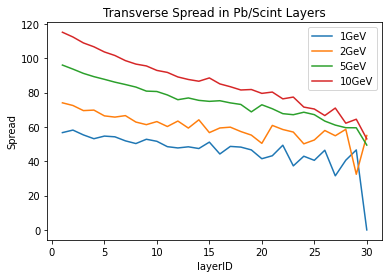

In [6]:
spread(samples['zdc_neutron_1GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_2GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_5GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
plt.legend(["1GeV", "2GeV", "5GeV", "10GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in Pb/Scint Layers")
plt.savefig("hcalspread.pdf")

In [7]:
spread(samples['zdc_neutron_1GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_5GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()

Text(0.5, 1.0, 'Transverse Spread in Pb/Scint Layers')

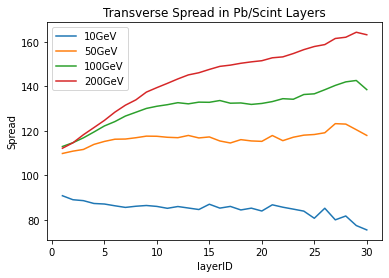

In [28]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDCHcalHits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in Pb/Scint Layers")
plt.savefig("hcalspread.pdf")

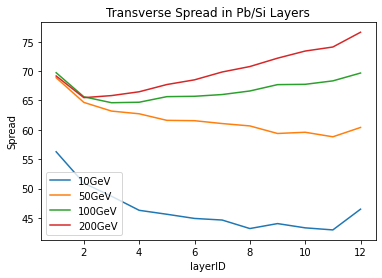

In [31]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDC_PbSi_Hits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in Pb/Si Layers")
plt.savefig("PbSispread.pdf")

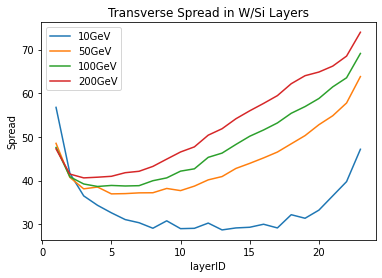

In [29]:
spread(samples['zdc_neutron_10GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_50GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_100GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
spread(samples['zdc_neutron_200GeV_10e4.edm4hep.root'], "ZDC_WSi_Hits", "x", 10000)[0].mean().plot()
plt.legend(["10GeV", "50GeV", "100GeV", "200GeV"])
plt.xlabel("layerID")
plt.ylabel("Spread")
plt.title("Transverse Spread in W/Si Layers")
plt.savefig("WSispread.pdf")

Shower Start

In [9]:
def start(data, branch, count):

    start = np.array([])

    for i in range(count):
        index = str(i)

        x_0 = np.array(data[f"{branch}.position.x"][i])
        y_0 = np.array(data[f"{branch}.position.y"][i])
        z_0 = np.array(data[f"{branch}.position.z"][i])
    
        axis_dict = {'x':x_0 * np.cos(CrossingAngle) + z_0 * np.sin(CrossingAngle), 'y':y_0}

        cellID = np.array(data[f"{branch}.cellID"][i])
        layerID = sorted(bitExtract(cellID, 6, 9))

        df = pd.DataFrame({f'{index}': axis_dict['x'], 'layerID': layerID})
        layers = df.groupby("layerID")[f'{index}']
        df_rms = df[{'layerID',f'{index}'}][~layers.apply(is_outlier)]
        
        if len(df_rms) != 0:
            df_std = df_rms.groupby("layerID").std().fillna(0)
            startID = df_std.ne(0).idxmax()
            start = np.append(start, startID)

    return start

Energy Deposition per Layer

In [10]:
def layer_edep(data, branch, count):
    edep = pd.DataFrame()

    for i in range(count):
        index = str(i)
        energies = np.array(data[f"{branch}.energy"][i])
        cellID = np.array(data[f"{branch}.cellID"][i])
        layerID = sorted(bitExtract(cellID, 6, 9))
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()

        if len(layers) != 0:
            edep = pd.concat([edep,layers], axis=1).replace(np.NaN,0)
            
    return edep

Total Energy Deposition

In [11]:
def total_edep(data, branch, count):
    total_edep = []
    for i in range(count):
        energies = np.array(data[f"{branch}.energy"][i])
        total_edep.append(sum(energies))
    return total_edep

Fractional Energy Deposition

In [12]:
def frac_edep(data, branch, count):
    edep = pd.DataFrame()

    for i in range(count):
        index = str(i)
        energies = np.array(data[f"{branch}.energy"][i])
        cellID = np.array(data[f"{branch}.cellID"][i])
        layerID = sorted(bitExtract(cellID, 6, 9))
        df = pd.DataFrame({f'{index}': energies, 'layerID': layerID})
        layers = df.groupby("layerID").sum()
        total_edep = layers.sum()[0]
        frac_edep_layers = layers/total_edep
        
        if len(layers) != 0:
            edep = pd.concat([edep,frac_edep_layers], axis=1).replace(np.NaN,0)
            
    return edep

Total Energy Deposition in All ZDC Components

In [13]:
def components_edep(data, count):
    SiPix_edep = []
    Crystal_edep = []
    WSi_edep = []
    PbSi_edep = []
    PbScint_edep = []
    energylabels = []
    
    for i in range(count):
        SiPix_energies = np.array(data["ZDC_SiliconPix_Hits.energy"][i])
        SiPix_edep.append(sum(SiPix_energies))

        Crystal_energies = np.array(data["ZDCEcalHits.energy"][i])
        Crystal_edep.append(sum(Crystal_energies))

        WSi_energies = np.array(data["ZDC_WSi_Hits.energy"][i])
        WSi_edep.append(sum(WSi_energies))

        PbSi_energies = np.array(data["ZDC_PbSi_Hits.energy"][i])
        PbSi_edep.append(sum(PbSi_energies))

        PbScint_energies = np.array(data["ZDCHcalHits.energy"][i])
        PbScint_edep.append(sum(PbScint_energies))

        label = np.sqrt(data["MCParticles.momentum.x"][0,0]**2 + data["MCParticles.momentum.y"][0,0]**2 + data["MCParticles.momentum.z"][0,0]**2)
        energylabels.append(label)

    return pd.DataFrame([SiPix_edep, Crystal_edep, WSi_edep, PbSi_edep, PbScint_edep, energylabels])

In [14]:
#Data for linear regression
data = [components_edep(samples[key],10000) for key in samples]
data_df = pd.concat(data,axis=1)

In [16]:
#Data for deep neural network
data = [layer_edep(samples[key],f'{component}',10000) for key in samples for component in Components]
data_df = pd.concat(data,axis=1)

Torch

In [15]:
import torch
from torch import nn

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/dmisra/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [17]:
torch.manual_seed(42)

Linear Regression

In [18]:
data_tensor_10GeV = torch.from_numpy(data[3].values).T.float()
data_tensor_50GeV = torch.from_numpy(data[0].values).T.float()
data_tensor_100GeV = torch.from_numpy(data[1].values).T.float()
data_tensor_200GeV = torch.from_numpy(data[2].values).T.float()

In [19]:
data_tensor = torch.from_numpy(data_df.values).T.float()

In [20]:
def features(tensor):
    return tensor[:,:5]

def labels(tensor):
    return tensor[:,5].unsqueeze(dim=1)

In [21]:
x = features(data_tensor)
y = labels(data_tensor)

In [22]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

input_size = 5
output_size = 1

In [23]:
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(input_size,output_size)

    def forward(self,x):
        out = self.linear(x) 
        return out

In [24]:
model_0 = LinearRegression(input_size,output_size)

In [25]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=learning_rate)

In [26]:
#Set number of epochs
epochs = 1000000

#Create lists to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ###Training
    model_0.train()
    y_pred = model_0(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ###Testing
    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(x_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 1000 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")


Epoch: 0 | MSE Train Loss: 12999.09375 | MSE Test Loss: 12635.837890625
Epoch: 1000 | MSE Train Loss: 2217.238037109375 | MSE Test Loss: 2215.304931640625
Epoch: 2000 | MSE Train Loss: 1737.1954345703125 | MSE Test Loss: 1751.7039794921875
Epoch: 3000 | MSE Train Loss: 1485.4832763671875 | MSE Test Loss: 1504.135009765625
Epoch: 4000 | MSE Train Loss: 1312.8587646484375 | MSE Test Loss: 1333.1322021484375
Epoch: 5000 | MSE Train Loss: 1187.6942138671875 | MSE Test Loss: 1208.5225830078125
Epoch: 6000 | MSE Train Loss: 1093.6754150390625 | MSE Test Loss: 1114.460693359375
Epoch: 7000 | MSE Train Loss: 1021.15283203125 | MSE Test Loss: 1041.5565185546875
Epoch: 8000 | MSE Train Loss: 963.9163208007812 | MSE Test Loss: 983.7579956054688
Epoch: 9000 | MSE Train Loss: 917.7440185546875 | MSE Test Loss: 936.9386596679688
Epoch: 10000 | MSE Train Loss: 879.6707153320312 | MSE Test Loss: 898.1885986328125
Epoch: 11000 | MSE Train Loss: 847.5763549804688 | MSE Test Loss: 865.4183349609375
Epoch

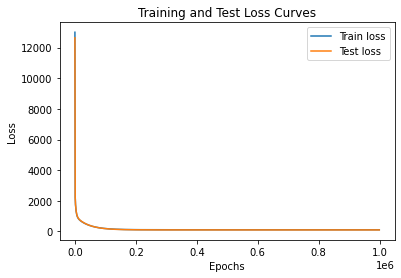

In [27]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [28]:
# Find the model's learned parameters
print(model_0.state_dict())

OrderedDict([('linear.weight', tensor([[  1.2579,   1.1551, 100.6723, 400.0780,  60.3600]])), ('linear.bias', tensor([2.8420]))])


Predictions

Text(0.5, 1.0, 'Predicted Energy Distribution')

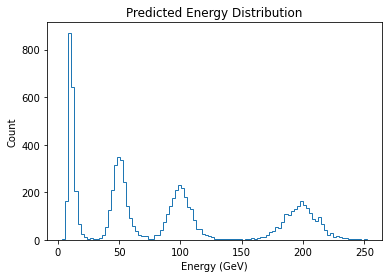

In [29]:
#Set the model in evaluation mode
model_0.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(x_test)

plt.hist(y_preds[:,0].numpy(),100,histtype='step')
plt.xlabel('Energy (GeV)')
plt.ylabel('Count')
plt.title('Predicted Energy Distribution')

In [30]:
#Set the model in evaluation mode
model_0.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds_200GeV = model_0(features(data_tensor_200GeV))
  y_preds_100GeV = model_0(features(data_tensor_100GeV))
  y_preds_50GeV = model_0(features(data_tensor_50GeV))
  y_preds_10GeV = model_0(features(data_tensor_10GeV))

In [31]:
peak_preds = norm.fit(y_preds_10GeV)[0], norm.fit(y_preds_50GeV)[0], norm.fit(y_preds_100GeV)[0], norm.fit(y_preds_200GeV)[0]
true_peaks = [10,50,100,200]
peak_preds

(11.561301, 51.061886, 100.06319, 197.48654)

Text(0.5, 1.0, 'Linearity')

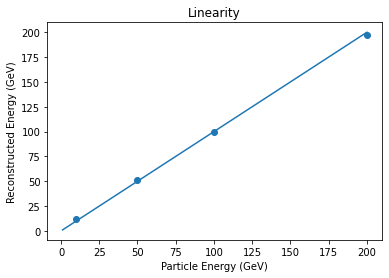

In [32]:
plt.scatter(true_peaks,peak_preds)
plt.xlabel('Particle Energy (GeV)')
plt.ylabel('Reconstructed Energy (GeV)')
plt.plot(np.arange(1,201),np.arange(1,201))
plt.title('Linearity')

In [33]:
#Get energy resolution from distribution of predictions
def res(preds,energy):
    return norm.fit(preds)[1]/energy

energy_list = [200,100,50,10]
resolutions = res(y_preds_200GeV,200), res(y_preds_100GeV,100), res(y_preds_50GeV,50), res(y_preds_10GeV,10)

In [34]:
#Curve fit for energy resolution as a function of energy
def f(E,a):
    return a/np.sqrt(E)

popt, pcov = curve_fit(f, energy_list, resolutions)

Text(0.5, 1.0, 'Energy Resolution')

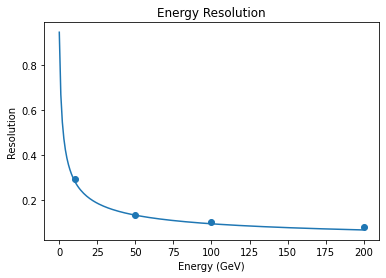

In [35]:
plt.plot(range(200),f(range(1,201),popt[0]))
plt.scatter(energy_list,resolutions)
plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')
plt.title('Energy Resolution')

In [36]:
torch.save(obj=model_0.state_dict, f="/home/dmisra/eic/model_0")

Deep Neural Network

In [ ]:
data_tensor = torch.from_numpy(data_df.values).T.float()

In [ ]:
def features(tensor):
    return tensor[:,:5]

def labels(tensor):
    return tensor[:,5].unsqueeze(dim=1)

In [ ]:
x = features(data_tensor)
y = labels(data_tensor)

In [ ]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

input_size = 5
output_size = 1